## Time Series Clustering via Community Detection in Networks


The following papaer https://arxiv.org/pdf/1508.04757v1.pdf describes 4 steps to identify Timeseries clusters.
<br>(1) data normalization
<br>(2) distance function calculation
<br>(3) network construction
<br>(4) community detection

We have implemented these steps in Python

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from glob import glob
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.metrics import dtw

C:\Users\akshaya.p.kadidal\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [130]:
import networkx as nx
#from neo4j import GraphDatabase, basic_auth
from networkx.algorithms import community
import community as community_louvain

In [2]:
os.chdir(r'C:\Users\akshaya.p.kadidal\Desktop\Anomaly Comparison\Anomaly KPIs')

In [3]:
d1 = pd.DataFrame()

In [4]:
filenames = glob('*.xlsx')

Reading All files in the folder

In [5]:
for f in filenames:
    data = pd.read_excel(f, parse_dates=[['Date', 'Time']])
    data = data.set_index('Date_Time')
    data = data.sort_values(by = 'Date_Time')
    data = data.drop(['Geography','Node'], axis=1, errors='ignore')
    d1 = pd.concat([d1, data], axis=1, join='outer')

### (1) Data normalization

In [6]:
def Clean_ts(df):
    object_columns = df.select_dtypes(include='object').describe()
    remove_columns = object_columns.loc['unique',:]==1
    
    columns_to_remove = remove_columns[remove_columns==1].index
    columns_to_remove = columns_to_remove.to_list()
    columns_to_retain = remove_columns[remove_columns!=1].index
    columns_to_retain = columns_to_retain.to_list()
    df = df.drop(columns_to_remove, axis=1)
    
    for j in columns_to_retain:
        df[j] = pd.to_numeric(df[j],errors='coerce')
        
    
    columns = df.select_dtypes(include=['float64','int64']).columns
    
    #Outlier Treatment Replace any value more than 1.5 of IQR with 99th Percentile value
    for i in columns:
        q1 = df[i].quantile(.25)
        q3 = df[i].quantile(.75)
        iqr = (q3-q1)*1.5
        ptile99 = df[i].quantile(.99)
        ptile01 = df[i].quantile(.01)
        skew = df[i].skew()
        kurt = df[i].kurtosis()
        if (q3 + iqr) > ptile99 :
            df.loc[df[i] > (q3 + iqr),i] = ptile99
        else :
            df.loc[df[i] > (q3 + iqr),i] = (q3 + iqr)
        
        if q1 - iqr < ptile01 :
            df.loc[df[i] < (q1 - iqr),i] = ptile01
        else :
            df.loc[df[i] < (q1 - iqr),i] = (q1 - iqr)
        
        df = df.replace('-',np.NAN)
        #standardize values
        X = StandardScaler().fit_transform(df[i].values.reshape(-1,1))
        df[i] = X
       
    return(df)

In [7]:
dt = Clean_ts(d1)

In [8]:
#get unix epoch time
dt['UnixTime'] = dt.index.astype(np.int64) // 10**9

In [9]:
#update NAN with 0
dt = dt.fillna(0)

In [ ]:
evalu = []

for k in range(10):
    
    km = TimeSeriesKMeans(n_clusters=k+2, verbose=True, random_state=23, metric="dtw")
    
    Y = km.fit_predict(dt.T)
    
    evalu.append(silhouette_score(dt.T, Y, metric="dtw"))

In [10]:
# the Knee chart for Silhouette score suggests 5 clusteres is best
km = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=23, metric="dtw")
    
Y = km.fit_predict(dt.drop('UnixTime', axis=1).T)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    7.9s finished


166.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    8.1s finished


106.409 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    8.0s finished


105.294 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    8.0s finished


105.294 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    7.9s finished


In [11]:
#Getting the list of groups
c1 =np.where(Y==0)[0].tolist()
c2 =np.where(Y==1)[0].tolist()
c3 =np.where(Y==2)[0].tolist()
c4 =np.where(Y==3)[0].tolist()
c5 =np.where(Y==4)[0].tolist()

In [13]:
%matplotlib inline

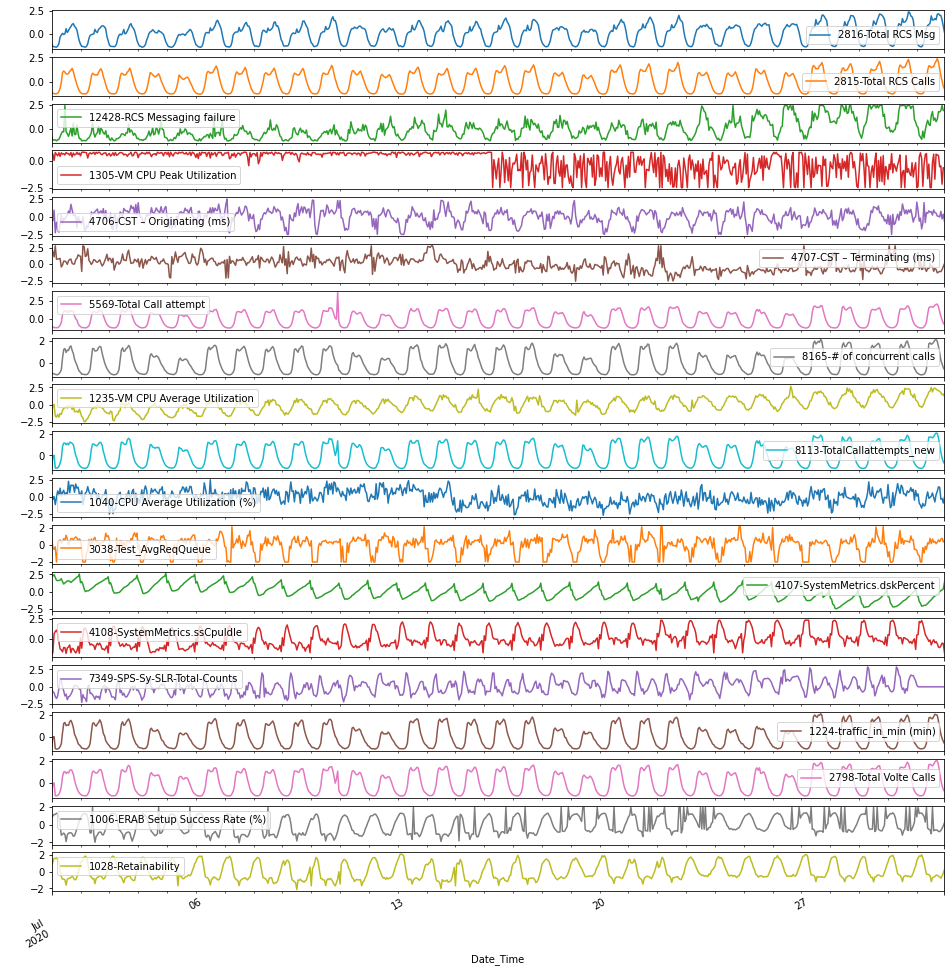

In [54]:
dt.iloc[:,c1].plot(subplots=True,figsize=(16,18));

In [15]:
#Following KPIs are part of this group
dt.iloc[:,c1].columns

Index(['2816-Total RCS Msg', '2815-Total RCS Calls',
       '12428-RCS Messaging failure', '1305-VM CPU Peak Utilization',
       '4706-CST – Originating (ms)', '4707-CST – Terminating (ms)',
       '5569-Total Call attempt', '8165-# of concurrent calls',
       '1235-VM CPU Average Utilization', '8113-TotalCallattempts_new',
       '1040-CPU Average Utilization (%)', '3038-Test_AvgReqQueue',
       '4107-SystemMetrics.dskPercent', '4108-SystemMetrics.ssCpuIdle',
       '7349-SPS-Sy-SLR-Total-Counts', '1224-traffic_in_min (min)',
       '2798-Total Volte Calls', '1006-ERAB Setup Success Rate (%)',
       '1028-Retainability'],
      dtype='object')

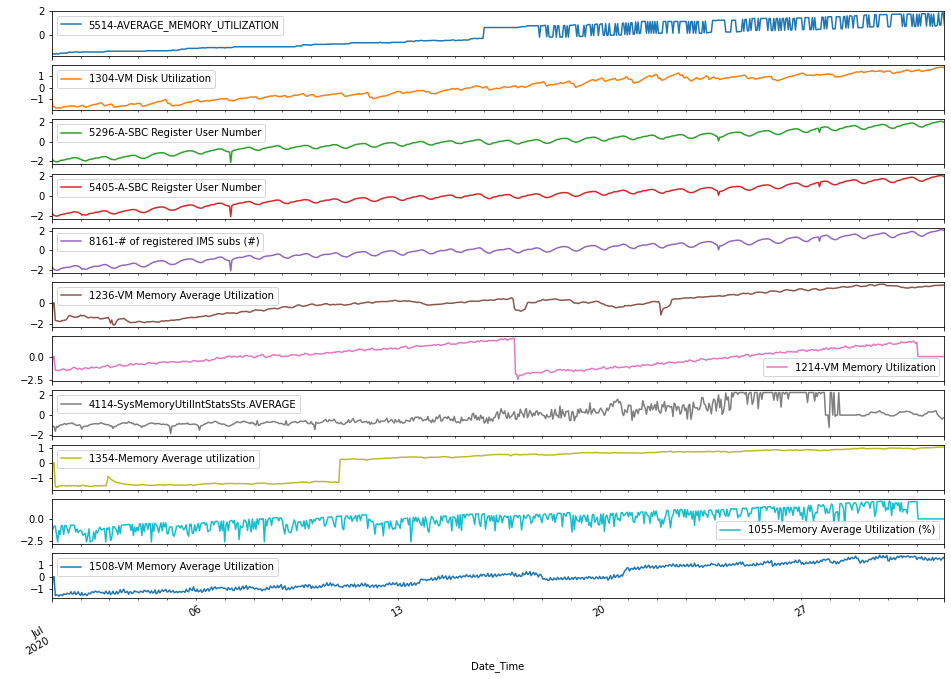

In [52]:
dt.iloc[:,c2].plot(subplots=True,figsize=(16,12));

In [17]:
#Following KPIs are part of this group
dt.iloc[:,c2].columns

Index(['5514-AVERAGE_MEMORY_UTILIZATION', '1304-VM Disk Utilization',
       '5296-A-SBC Register User Number', '5405-A-SBC Reigster User Number',
       '8161-# of registered IMS subs (#)',
       '1236-VM Memory Average Utilization', '1214-VM Memory Utilization',
       '4114-SysMemoryUtilIntStatsSts.AVERAGE',
       '1354-Memory Average utilization',
       '1055-Memory Average Utilization (%)',
       '1508-VM Memory Average Utilization'],
      dtype='object')

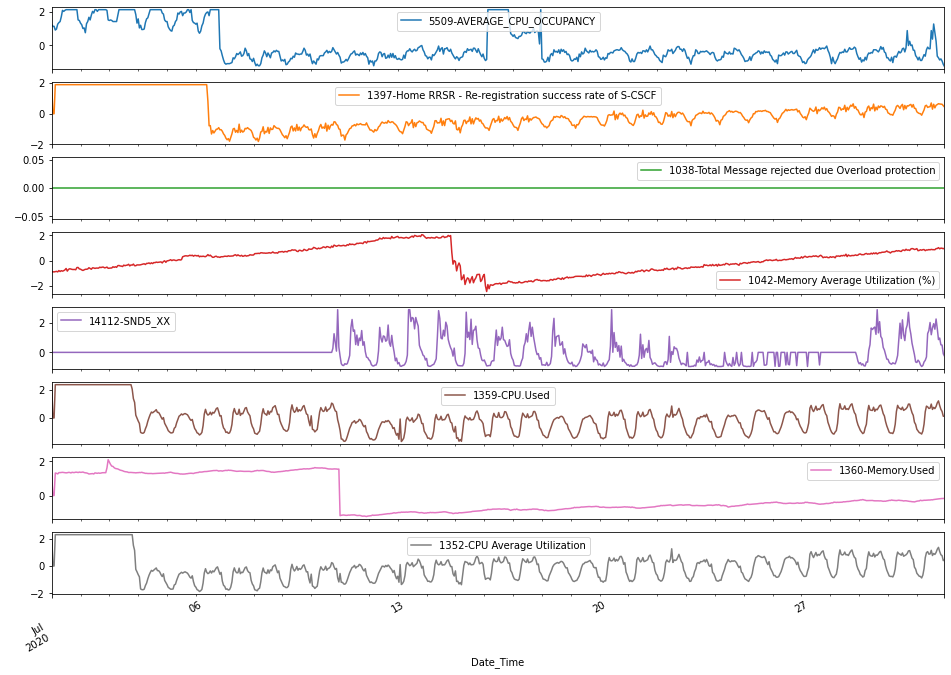

In [51]:
dt.iloc[:,c3].plot(subplots=True,figsize=(16,12));

In [19]:
#Following KPIs are part of this group
dt.iloc[:,c3].columns

Index(['5509-AVERAGE_CPU_OCCUPANCY',
       '1397-Home RRSR - Re-registration success rate of S-CSCF',
       '1038-Total Message rejected due Overload protection',
       '1042-Memory Average Utilization (%)', '14112-SND5_XX', '1359-CPU.Used',
       '1360-Memory.Used', '1352-CPU Average Utilization'],
      dtype='object')

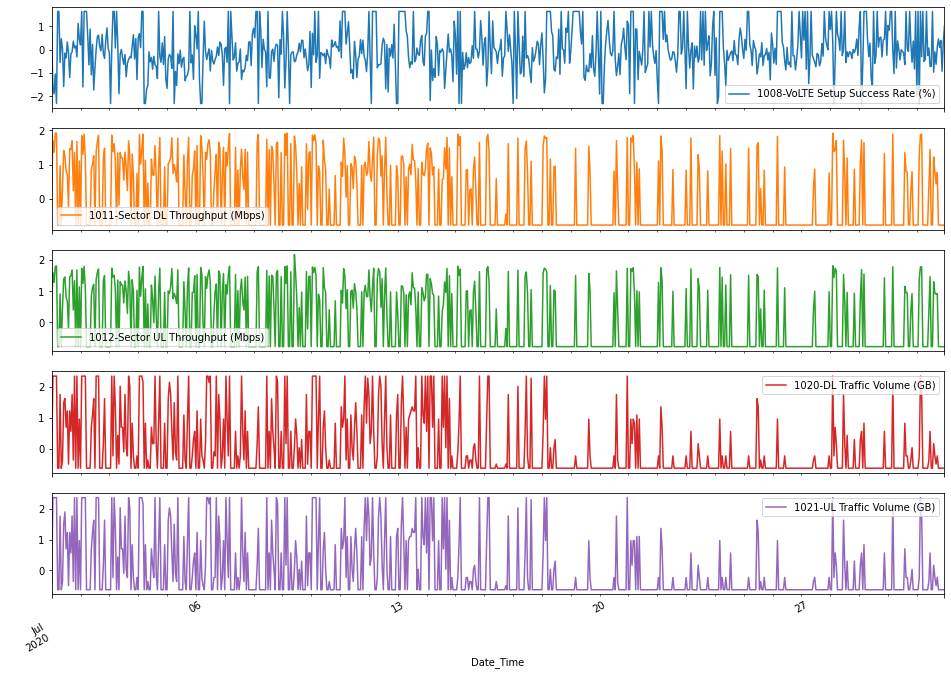

In [49]:
dt.iloc[:,c4].plot(subplots=True, figsize=(16,12));

In [21]:
#Following KPIs are part of this group
dt.iloc[:,c4].columns

Index(['1008-VoLTE Setup Success Rate (%)', '1011-Sector DL Throughput (Mbps)',
       '1012-Sector UL Throughput (Mbps)', '1020-DL Traffic Volume (GB)',
       '1021-UL Traffic Volume (GB)'],
      dtype='object')

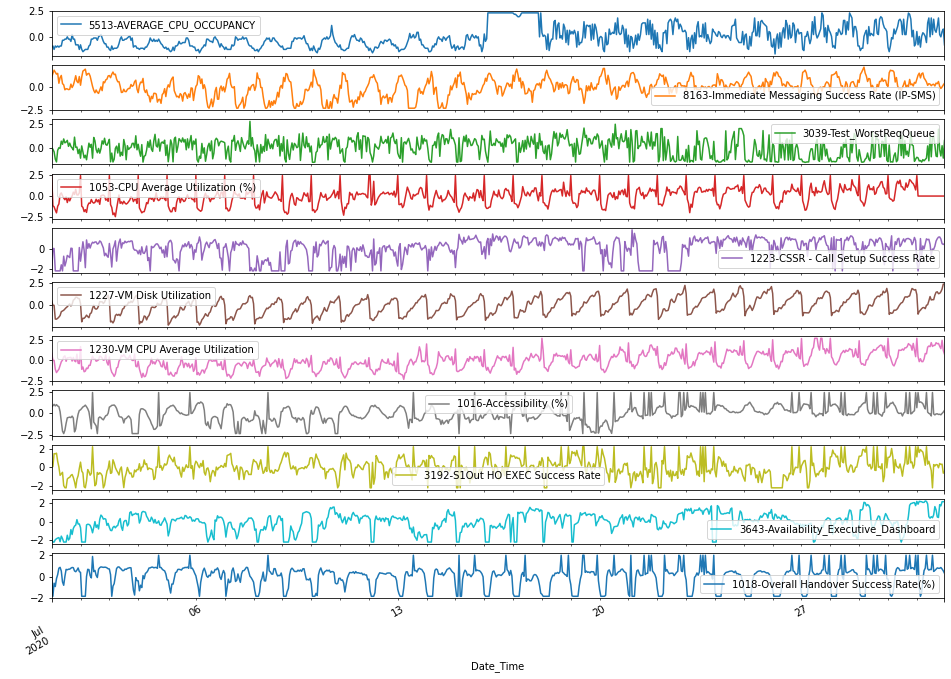

In [50]:
dt.iloc[:,c5].plot(subplots=True,figsize=(16,12));

In [23]:
#Following KPIs are part of this group
dt.iloc[:,c5].columns

Index(['5513-AVERAGE_CPU_OCCUPANCY',
       '8163-Immediate Messaging Success Rate (IP-SMS)',
       '3039-Test_WorstReqQueue', '1053-CPU Average Utilization (%)',
       '1223-CSSR - Call Setup Success Rate', '1227-VM Disk Utilization',
       '1230-VM CPU Average Utilization', '1016-Accessibility (%)',
       '3192-S1Out HO EXEC Success Rate',
       '3643-Availability_Executive_Dashboard',
       '1018-Overall Handover Success Rate(%)'],
      dtype='object')

In [24]:
# creating a distance table based on DTW distance
KPI1 = []
KPI2 = []
DTWCorel = []
Corel = []

for l in dt.columns:
    for m in dt.columns:
        KPI1.append(l)
        KPI2.append(m)
        DTWCorel.append(dtw(dt[l],dt[m]))
        Corel.append(dt[l].corr(dt[m]))

In [25]:
CM = pd.DataFrame({'KPI1': KPI1,
    'KPI2': KPI2,
    'DTWCorel': DTWCorel,
    'Corel': Corel})

In [26]:
#removing same corelations
CM =  CM[CM['KPI1']!=CM['KPI2']]
CM = CM.sort_values(by = 'DTWCorel')

### (2) Distance function calculation (DTW)

Creating distance Matrix

In [82]:
# Creting DTW distance Matrix
def create_dm(dt):
    s = dt.shape[1]
    cm = np.zeros((s,s))

    for l in range(s-1):
        for m in range(s-1):
            cm[l,m] = dtw(dt.iloc[:,l],dt.iloc[:,m])
    return (cm)

In [83]:
dm = create_dm(dt)

### (3) Network construction (using Epslon Nearest Neighbour to generate adjacency Matrix)

In [90]:
def create_adjmtxr(dm, epslon):
    s = dm.shape[1]
    n = np.zeros((s,s))
    n[dm < epslon] = 1
    return (n)    

In [92]:
n = create_adjmtxr(dm, 15)

In [95]:
G = nx.from_numpy_matrix(n)

### (4) community detection

In [98]:
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
Level2_Communities = next(communities_generator)
Level3_Communities = next(communities_generator)
Level4_Communities = next(communities_generator)
Level5_Communities = next(communities_generator)
Level6_Communities = next(communities_generator)

In [99]:
sorted(map(sorted, Level6_Communities))

In [ ]:
dt.iloc[:,[44]].plot(subplots=True, figsize=(16,4));

Using Louvain algorithm to detect Communities

In [128]:
partition = community_louvain.best_partition(G)

In [126]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

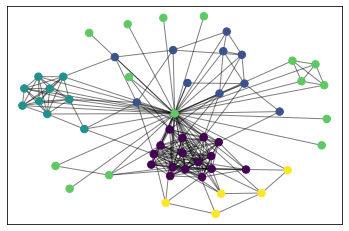

In [244]:
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=55, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
#plt.legend()
plt.show()

In [212]:
attributes = pd.read_excel('KPI_Atrributes.xlsx')

In [215]:
attrs = attributes.to_dict()

In [234]:
attributes.groupby(['Cluster','Domain']).count()

KPIName
Cluster Domain                  
1       MavenirRCSMsg          1
        MavenirRCSVoice        2
        NokiaASBC              3
        NokiaCSCF              2
        NokiaFlowline          1
        NokiaSPS               1
        NokiaTAS               4
        NokiaXA                1
        RAN                    1
2       MavenirRCSMsg          1
        NokiaCSCF              1
        NokiaCSD               1
        NokiaFlowline          1
        NokiaHSS               1
        NokiaRibnSBC           2
        NokiaSDL               3
3       MavenirRCSVoice        1
        NokiaASBC              4
        NokiaCSCF              1
        NokiaSDL               1
        NokiaSPS               1
        NokiaTAS               1
4       NokiaASBC              2
        NokiaCSD               2
        NokiaFlowline          1
        NokiaSPS               1
        RAN                    8
5       NokiaASBC              1
        NokiaFlowline          1
        NokiaTAS               1
        RAN                    2

In [216]:
nx.set_node_attributes(G, attrs)

#### Connecting to Neo4j Graph Database (this will allow you to apply louvain algorithm at scale and on stream data)

In [239]:
from neo4j import GraphDatabase, basic_auth
from tabulate import tabulate
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "graph"))

In [240]:
result = {"label": [], "count": []}
with driver.session() as session:
    labels = [row["label"] for row in session.run("CALL db.labels()")]
    for label in labels:
        query = f"MATCH (:`{label}`) RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["label"].append(label)
        result["count"].append(count)
df = pd.DataFrame(data=result)
print(tabulate(df.sort_values("count"), headers='keys',
tablefmt='psql', showindex=False))

+---------+---------+
| label   |   count |
|---------+---------|
| KPI     |      54 |
+---------+---------+


In [241]:
from neo4j import GraphDatabase, basic_auth
driver = GraphDatabase.driver(uri,
    auth=basic_auth("neo4j", "graph"))

In [242]:
import neo4jupyter
neo4jupyter.init_notebook_mode()

<IPython.core.display.Javascript object>

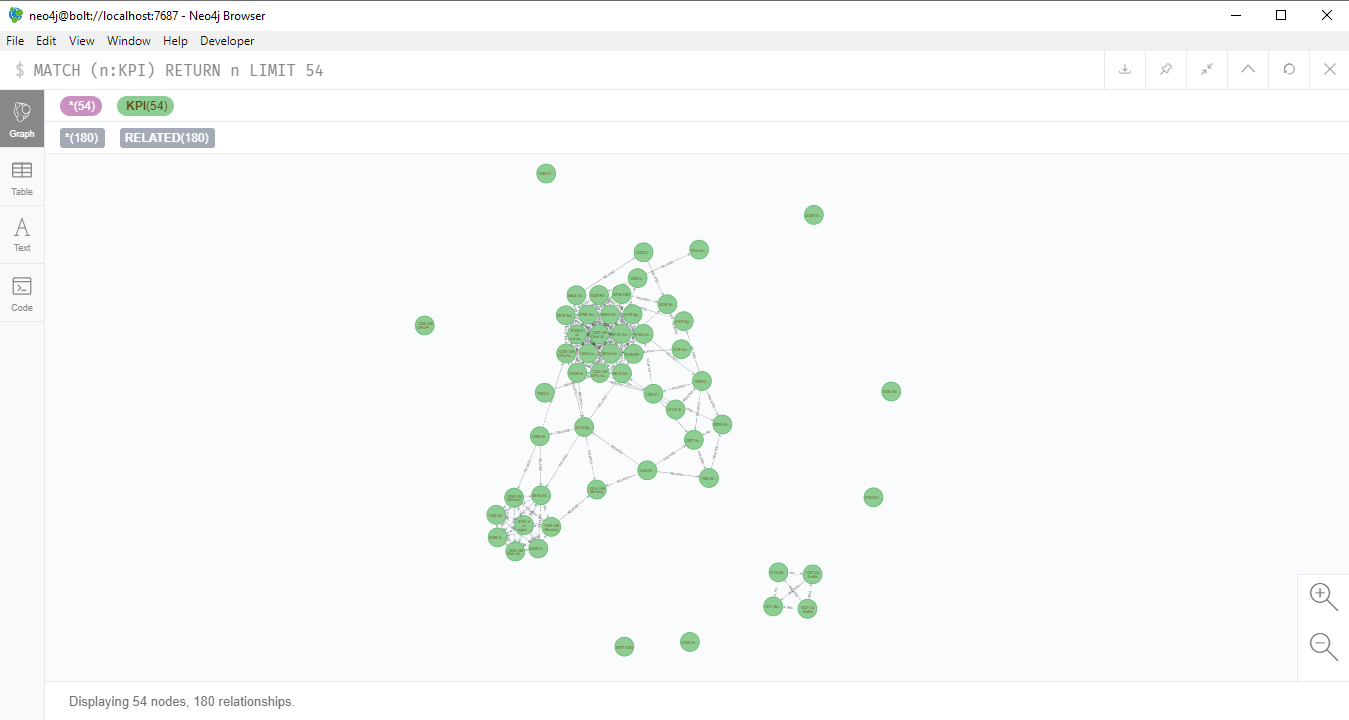

In [174]:
#Getting the list of groups
cl1 =np.where(np.array(list(partition.values()))==0)[0].tolist()
cl2 =np.where(np.array(list(partition.values()))==1)[0].tolist()
cl3 =np.where(np.array(list(partition.values()))==2)[0].tolist()
cl4 =np.where(np.array(list(partition.values()))==3)[0].tolist()
cl5 =np.where(np.array(list(partition.values()))==4)[0].tolist()

In [185]:
dt.iloc[:,cl1].columns

Index(['2816-Total RCS Msg', '2815-Total RCS Calls',
       '5513-AVERAGE_CPU_OCCUPANCY', '12428-RCS Messaging failure',
       '5569-Total Call attempt',
       '8163-Immediate Messaging Success Rate (IP-SMS)',
       '8165-# of concurrent calls', '1235-VM CPU Average Utilization',
       '8113-TotalCallattempts_new', '4108-SystemMetrics.ssCpuIdle',
       '7349-SPS-Sy-SLR-Total-Counts', '1224-traffic_in_min (min)',
       '1227-VM Disk Utilization', '1230-VM CPU Average Utilization',
       '2798-Total Volte Calls', '1028-Retainability'],
      dtype='object')

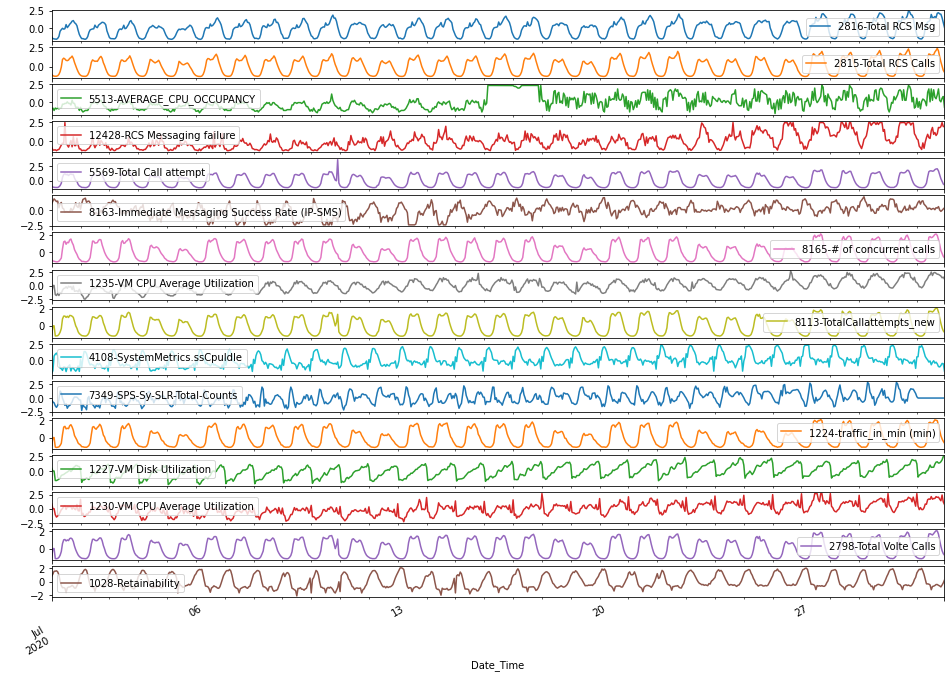

In [175]:
# Cluster number 1
dt.iloc[:,cl1].plot(subplots=True,figsize=(16,12));

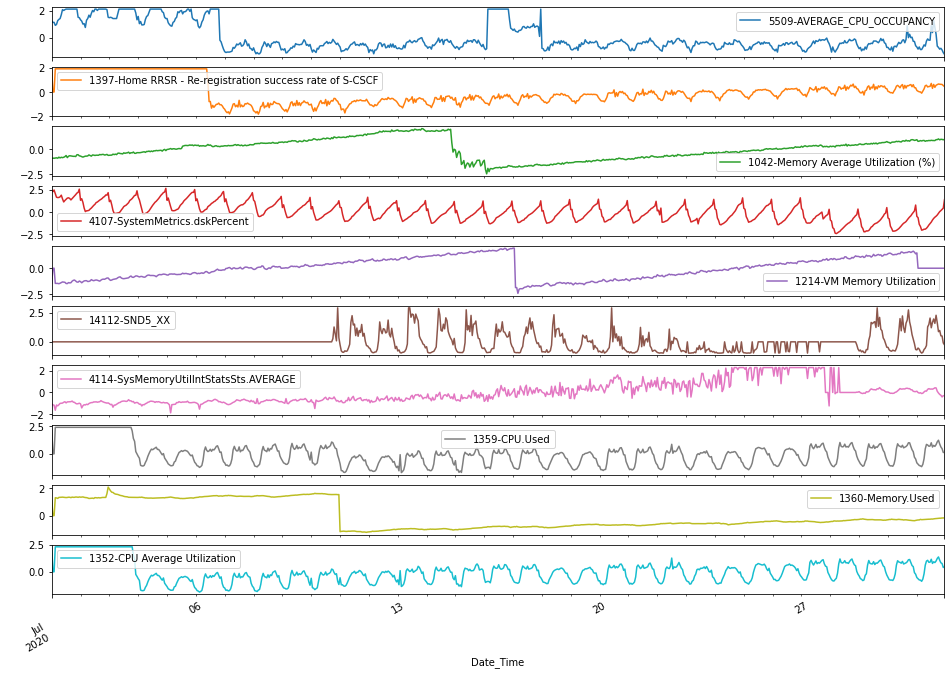

In [176]:
# Cluster number 2
dt.iloc[:,cl2].plot(subplots=True,figsize=(16,12));

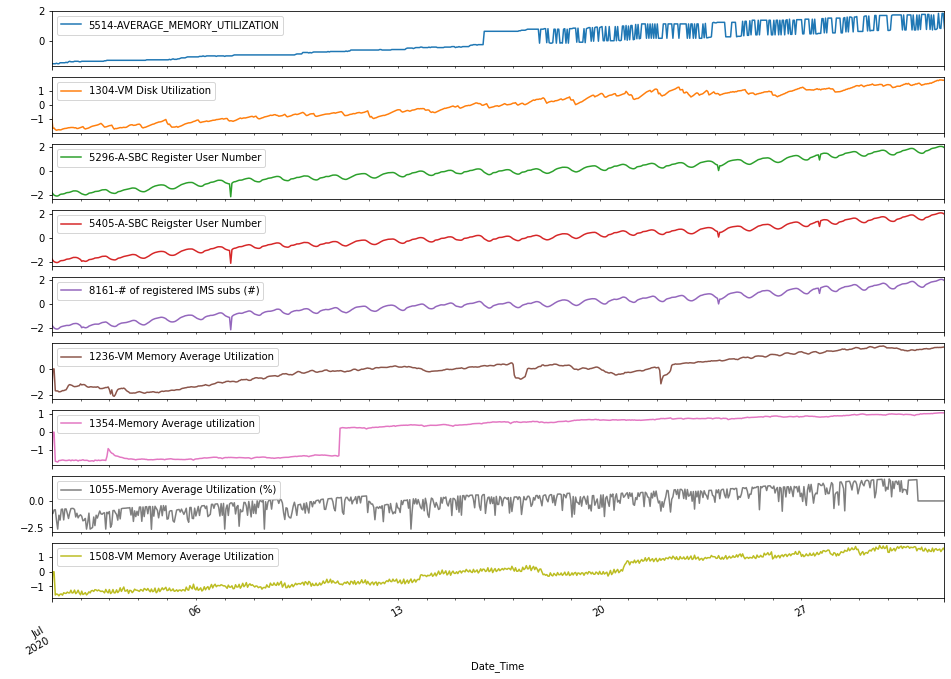

In [177]:
# Cluster number 3
dt.iloc[:,cl3].plot(subplots=True,figsize=(16,12));

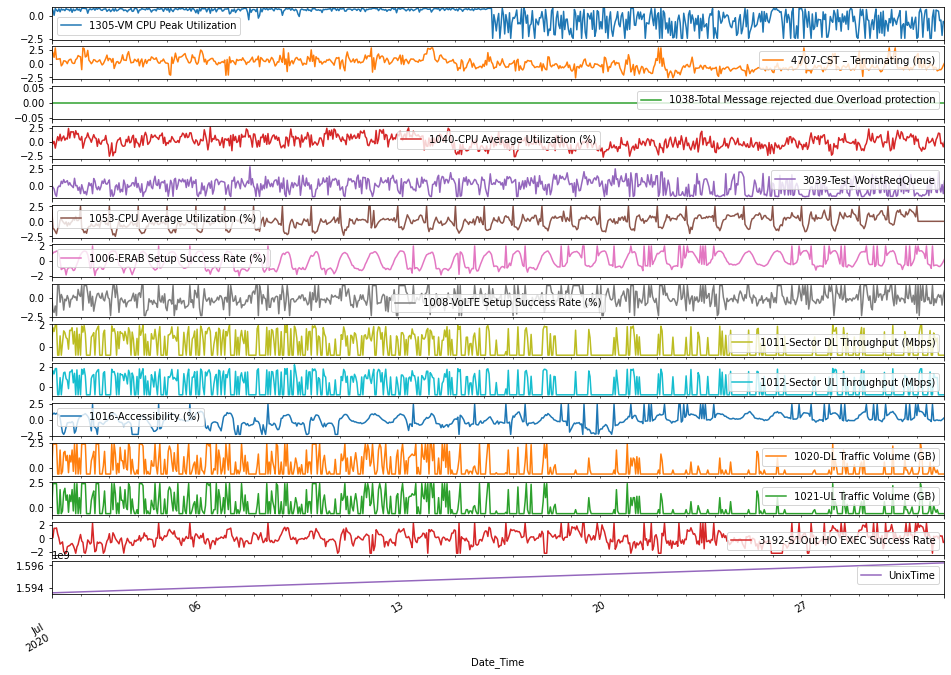

In [178]:
# Cluster number 4
dt.iloc[:,cl4].plot(subplots=True,figsize=(16,12));

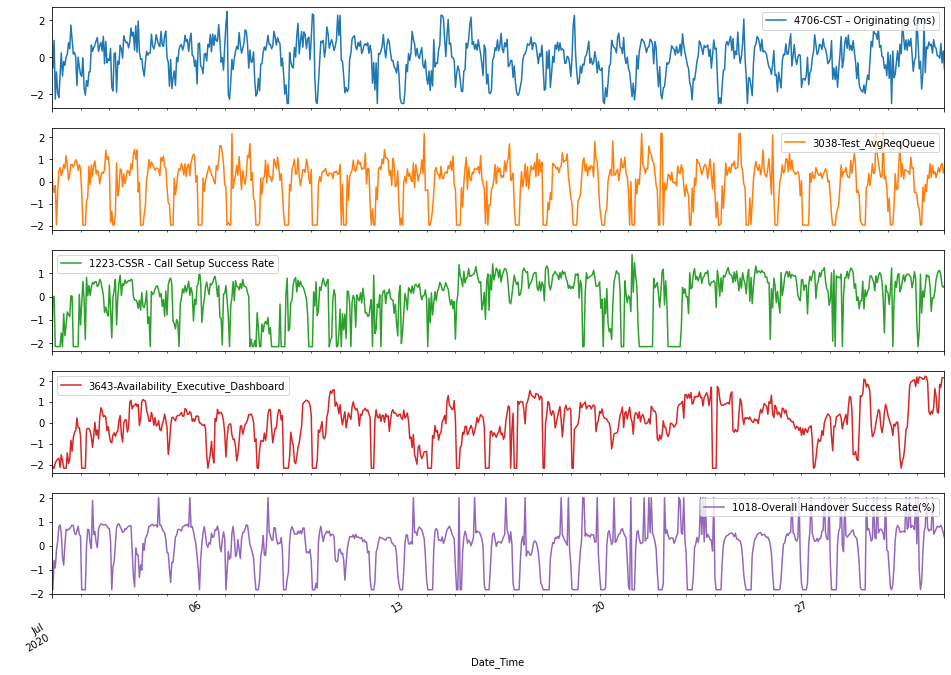

In [179]:
# Cluster number 5
dt.iloc[:,cl5].plot(subplots=True,figsize=(16,12));

Some Interesting corelations from across domains

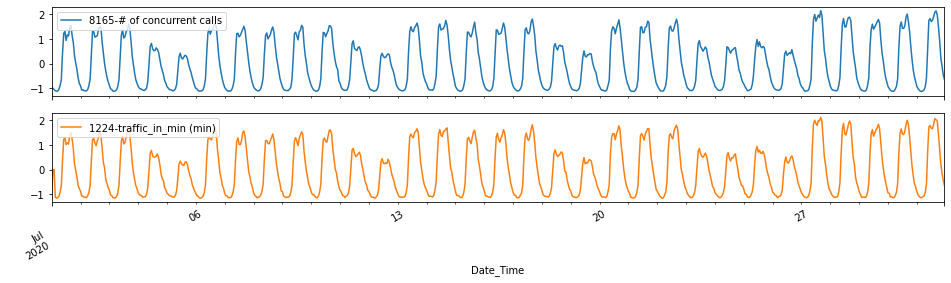

In [61]:
dt[['8165-# of concurrent calls','1224-traffic_in_min (min)']].plot(subplots=True,figsize=(16,4));

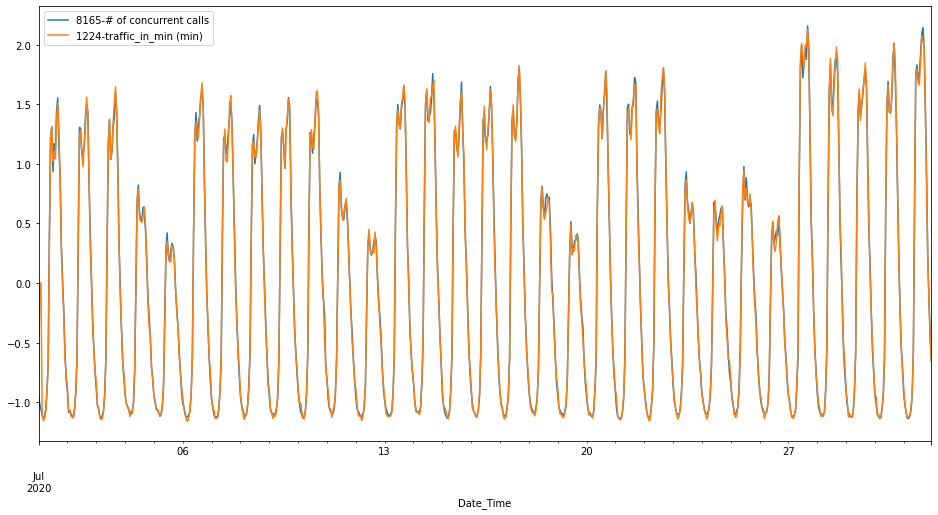

In [62]:
#almost perfectly sitting on top of each other -- one is a TAS KPI another is a ASBC KPI
dt[['8165-# of concurrent calls','1224-traffic_in_min (min)']].plot(figsize=(16,8));

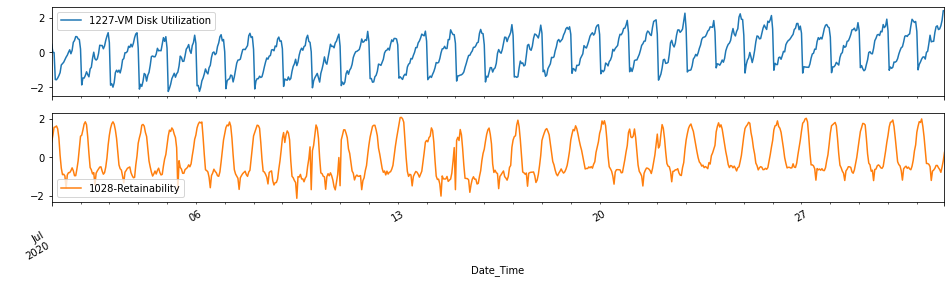

In [36]:
dt[['1227-VM Disk Utilization','1028-Retainability']].plot(subplots=True,figsize=(16,4));

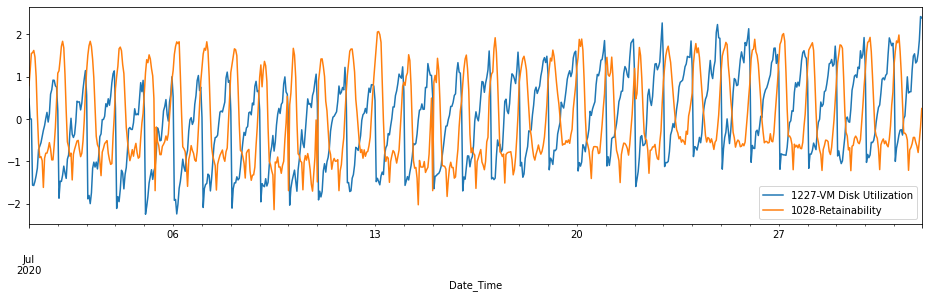

In [38]:
dt[['1227-VM Disk Utilization','1028-Retainability']].plot(figsize=(16,4));

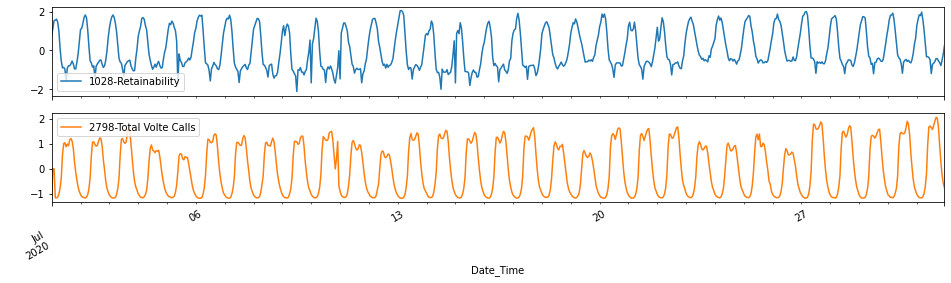

In [40]:
dt[['1028-Retainability','2798-Total Volte Calls']].plot(subplots=True,figsize=(16,4));

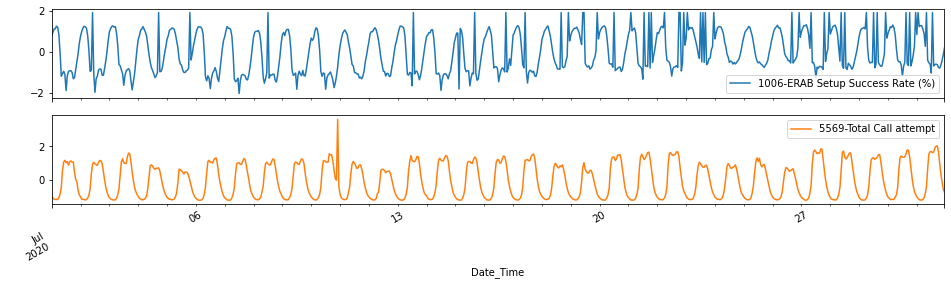

In [39]:
dt[['1006-ERAB Setup Success Rate (%)','5569-Total Call attempt']].plot(figsize=(16,4),subplots=True);

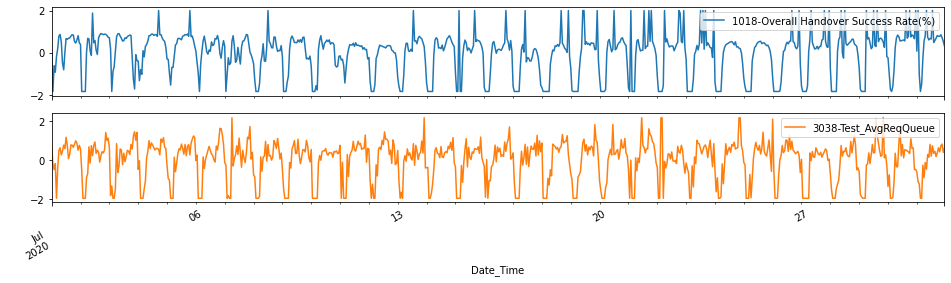

In [57]:
dt[['1018-Overall Handover Success Rate(%)','3038-Test_AvgReqQueue']].plot(subplots=True, figsize=(16,4));

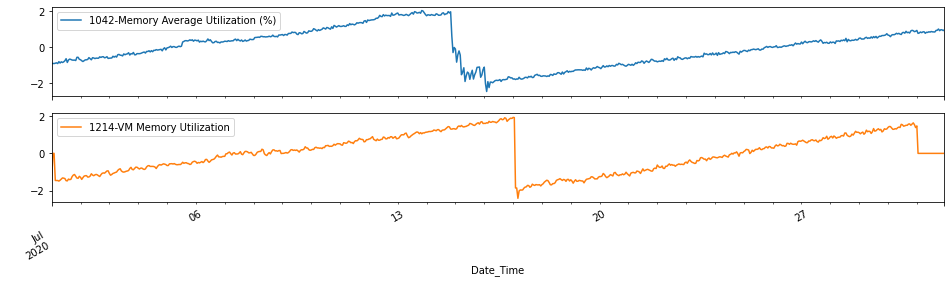

In [58]:
dt[['1042-Memory Average Utilization (%)','1214-VM Memory Utilization']].plot(subplots=True,figsize=(16,4));